# Рекомендация тарифов

## Описание проекта

В моем распоряжении данные о поведении клиентов, которые уже перешли с архивных тарифов на действующие. Используя эти данные, необходимо построить модель, которая предложит наиболее подходящий тариф для пользователей архивных тарифов.

## Описание данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
+ *сalls* — количество звонков,
+ *minutes* — суммарная длительность звонков в минутах,
+ *messages* — количество sms-сообщений,
+ *mb_used* — израсходованный интернет-трафик в Мб,
+ *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

# 1. Загрузим и изучим данные

## Импортируем библиотеки

In [3]:
# Импортируем библиотеки
# для работы с данными
import pandas as pd
import numpy as np

# # для работы с датой
# import datetime
# from dateutil import relativedelta

# # Для работы со статистикой
# from scipy import stats as st

#Предупреждения
import warnings
warnings.filterwarnings('ignore')

#для загрузки данных
from pathlib import Path
import os
import urllib.request

# Для Графиков
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

#для построения моделей
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import graphviz

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
 

import joblib

### Загрузим и прочитаем сет с данными

In [4]:
#Cоздадим папку если ее нет
Path('datasets').mkdir(parents=True, exist_ok=True)

#словарь с именем файла и ссылкой на него
urls = {
    'users_behavior': ('https://code.s3.yandex.net/datasets/users_behavior.csv', 'datasets/users_behavior.csv'),
}

#Проверим есть ли файл
if not os.path.exists(urls.get('users_behavior')[1]):
    print(urls.get('users_behavior')[1], 'файл не найден, будет загружен из сети')
    #качаем файл по ссылке url, кладем по пути file_name
    urllib.request.urlretrieve(*urls.get('users_behavior'))
     
df =  pd.read_csv(urls['users_behavior'][1])

datasets/users_behavior.csv файл не найден, будет загружен из сети


## Изучим данные

In [73]:
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,19915.42,0
1,85.00,516.75,56.00,22696.96,0
2,77.00,467.66,86.00,21060.45,0
3,106.00,745.53,81.00,8437.39,1
4,66.00,418.74,1.00,14502.75,0
5,58.00,344.56,21.00,15823.37,0
6,57.00,431.64,20.00,3738.90,1
7,15.00,132.40,6.00,21911.60,0
8,7.00,43.39,3.00,2538.67,1
9,90.00,665.41,38.00,17358.61,0


In [74]:
df.info() #Пропусков нет, все выглядит прилично

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [75]:
#Переведем call в тип Int
df['calls'] = df['calls'].astype(int)

In [76]:
#Проверим дубликаты
df.duplicated().sum() #Дубликатов нет

0

In [77]:
#проверим основные метрики данных
pd.options.display.float_format = '{:.2f}'.format
df.describe(percentiles=[.05, .25, .5, .75, .95])

,calls,minutes,messages,mb_used,is_ultra
count,3214.00,3214.00,3214.00,3214.00,3214.00
mean,63.04,438.21,38.28,17207.67,0.31
std,33.24,234.57,36.15,7570.97,0.46
min,0.00,0.00,0.00,0.00,0.00
5%,10.00,69.64,0.00,4592.46,0.00
25%,40.00,274.58,9.00,12491.90,0.00
50%,62.00,430.60,30.00,16943.24,0.00
75%,82.00,571.93,57.00,21424.70,1.00
95%,120.00,838.23,106.00,30368.32,1.00
max,244.00,1632.06,224.00,49745.73,1.00


## Проверим корреляционные зависимости и выбросы

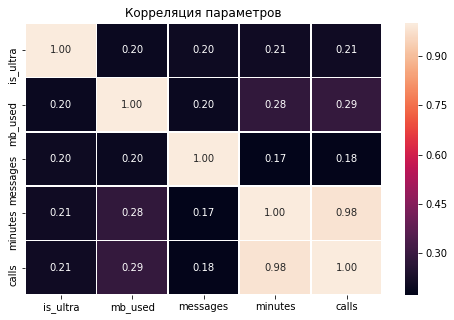

In [78]:
sns.heatmap(data=df[df.columns[ : : -1]].corr(),
    annot=True, fmt='0.2f', linewidths=.8
)
plt.title('Корреляция параметров')
plt.show()


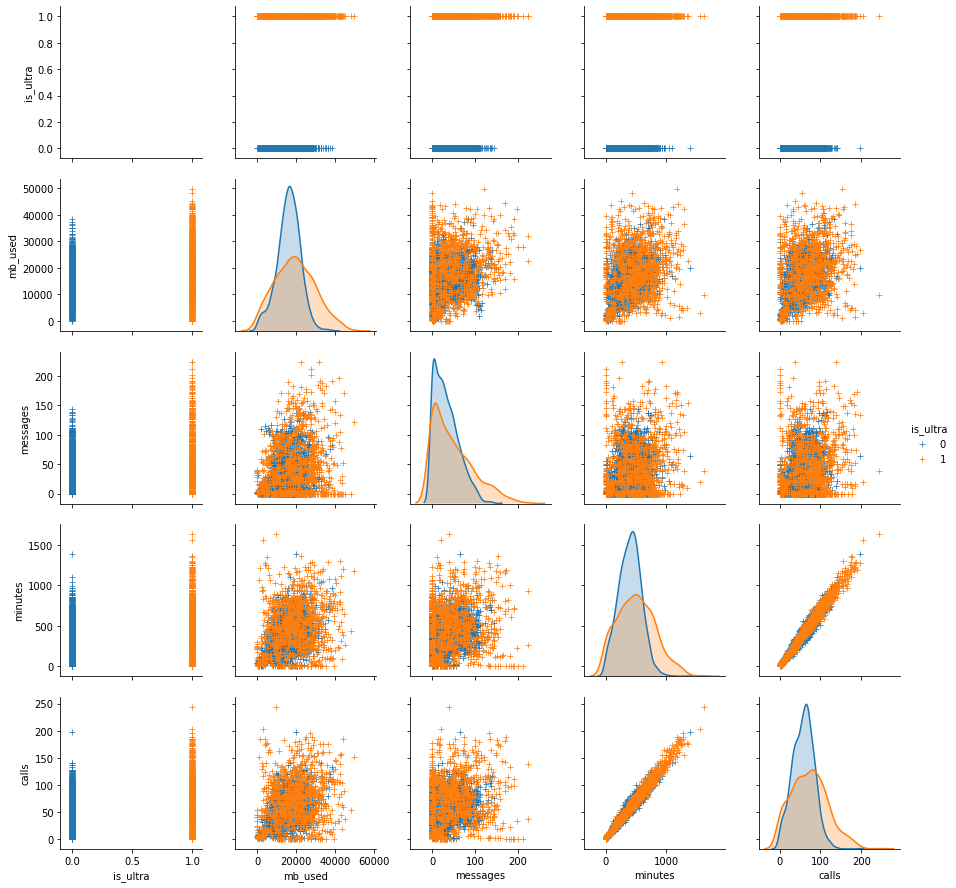

CPU times: user 13.5 s, sys: 1.31 s, total: 14.8 s
Wall time: 14.9 s


In [79]:
%%time
sns.pairplot(df[df.columns[ : : -1]], hue="is_ultra", markers="+")
plt.show()

### Вывод


1. При проверке корреляции, наблюдается равная степень зависимости от всех признаков, соответствующая приблизительно 0,2
2. Наблюдается корреляцинная зависимость между признаками `'calls'` и `'minutes'`: <br/> Для сравнения, лучший результат тестовой выборке при различном сочетании показали:
 + Исходные данные: Дерево решений, accuracy = 0.8009;
 + Исключили из столбцов признак `'calls'`: Дерево решений, равный 0.8056;
 + Исключили из столбцов признак `'minutes'`: Дерево решений, равный 0.7869 (но на валидации результаты самые высокие;
 + При этом, исключая столбцы, лучшая доля правильных ответов наблюдается на валидационной выборке и меньшая на тестовой
 
 
3. Исходя из этого будем строить модель на исходных данных без признака `'calls'`
4. Также наблюдаются выбросы для признаков `'calls'` при `'is_ultra' == 0` <br/> Удаление выбросов незначительно повысило качетво модели Логистической регрессии (на 2%). Но т.к. в конечном итоге лучший результат показала модель устойчивая к выбросам, Дерево решений, то приянто рещение строить модель без обработки выбросов

## Вывод

1. Данные выглядят вполне пригодными для анализа
2. Пропусков и дубликатов не обнаружено
3. Артефактных значенийй также не обнаружено
4. Доли значений целевого признака распределились в соотношении 69% (0) к 30% (1)

## 2. Подготовим данные для обучения

### Выделим целевой признак объекта и остальные признаки

X - Признаки объектов (звонки, сообщения, продолжительность, мегабайты) <br/>
у - Целевой признак (`is_ultra`)

In [80]:
X, y = df.drop(['is_ultra', 'calls'], axis=1), df['is_ultra']
print('Размер таблицы "X" с признаками:', X.shape, '\nРазмер колонки "y" с целевым признаком:', *y.shape)


Размер таблицы "X" с признаками: (3214, 3) 
Размер колонки "y" с целевым признаком: 3214


### Разделим выборку на тренировочную, валидационную и тестовую

Разделим сет на следующие выборки:
+ Тренировочную(60%) - X_train, y_train;
+ Валидационную(20%) - X_valid, y_valid;
+ Тестовую(20%) -  X_test, y_test.

Полученое соотношение делит сет в отношении 3:1:1.
Тестовую выборку скроем при обучении модели.

Выделим в качестве тестовой выборки 25% данных, на которых будем проверять лцчшую модель.
+ на X_train и y_train будем учиться
+ на y_test, будем проверять

In [81]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [82]:
print('Размер тренировочной таблицы "X_train" с признаками:',
      X_train.shape, '\nРазмер тренировочной колонки "y_train" с целевым признаком:', *y_train.shape)
print('\nРазмер тестового сета "X_test" с признаками:',
      X_test.shape, '\nРазмер тестовой колонки "y_test" с целевым признаком:', *y_test.shape)

Размер тренировочной таблицы "X_train" с признаками: (2571, 3) 
Размер тренировочной колонки "y_train" с целевым признаком: 2571

Размер тестового сета "X_test" с признаками: (643, 3) 
Размер тестовой колонки "y_test" с целевым признаком: 643


Возьмем в качестве вданных для валидации 25% от тренировочных сетаов X_train, y_train

In [83]:
 X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [84]:
print('Размер тренировочной таблицы "X_train" с признаками:',
      X_train.shape, '\nРазмер тренировочной колонки "y_train" с целевым признаком:', *y_train.shape)
print('\nРазмер тестового сета "X_valid" с признаками:',
      X_valid.shape, '\nРазмер тестовой колонки "y_valid" с целевым признаком:', *y_valid.shape)

Размер тренировочной таблицы "X_train" с признаками: (1928, 3) 
Размер тренировочной колонки "y_train" с целевым признаком: 1928

Размер тестового сета "X_valid" с признаками: (643, 3) 
Размер тестовой колонки "y_valid" с целевым признаком: 643


## Вывод

1. Мы разделили датасет на целевой признак(y), который будем предсказывать и не целевые признаки(X), по которым будем определять 'y'
2. Для обучения и проверки результатов модели мы разделили выборку на:
 + Тренировочную(60%) - X_train, y_train;
 + Валидационную(20%) - X_valid, y_valid;
 + Тестовую(20%) -  X_test, y_test.
3. Получили соотношение выборок 3:1:1
4. Объекты из тестовой выборки не входят в тренировочную и валидационную выборки

# 3. Построение модели

## Выбор моделей

Т.к. у нас категориальный параметр в качестве целевого признака, то будем использовать модели классификации
В качестве обучающих моделей выберем следующие:
+ Логистическая регрессия (LogisticRegression);
+ Дерево решений (DecisionTreeClassifier);
+ Случайный лес решений (RandomForestClassifier)

### Логистическая регрессия (LogisticRegression)

Воспользуемся рекомендациями из scikit-learn, т.к. у нас относительно не большой сет, то применим `solver='liblinear'`

In [85]:
model_lr = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', random_state=0)

model_lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [86]:
prediction_lr = model_lr.predict(X_valid)
accuracy_lr = accuracy_score(y_valid, prediction_lr)
print('Доля правильных ответов модели на основе Логистической регрессии', accuracy_lr)

Доля правильных ответов модели на основе Логистической регрессии 0.749611197511664


Проверим влияние параметра "С" на результат
проверим в диапазоне от 10$^-$$^4$ до 10$^4$

In [87]:
for с_value in np.logspace(-4, 4, num = 10):
    #Создадим новую модель для итераций
    _model_lr = LogisticRegression(C=с_value, penalty='l1', solver='liblinear', random_state=0)
    _model_lr.fit(X_train, y_train)
    #Предсказание и проверка
    _prediction_lr = _model_lr.predict(X_valid)
    _accuracy_lr = accuracy_score(y_valid, _prediction_lr)
    
    #Напечатаем результат
    print('При С = {:.4f}, Accuracy = {:.5f}'.format(с_value, _accuracy_lr))

При С = 0.0001, Accuracy = 0.69362
При С = 0.0008, Accuracy = 0.69673
При С = 0.0060, Accuracy = 0.69984
При С = 0.0464, Accuracy = 0.74184
При С = 0.3594, Accuracy = 0.74961
При С = 2.7826, Accuracy = 0.74961
При С = 21.5443, Accuracy = 0.74961
При С = 166.8101, Accuracy = 0.74961
При С = 1291.5497, Accuracy = 0.74961
При С = 10000.0000, Accuracy = 0.74961


При значении по умолчанию равному С=1.0 и вышее его доля правильных ответов не меняется

Проверим влияние max_iter=100

In [88]:
for max_iter_num in range(100, 551, 50):
    #Создадим новую модель для итераций
    _model_lr = LogisticRegression(max_iter=max_iter_num, penalty='l1', solver='liblinear', random_state=0)
    _model_lr.fit(X_train, y_train)
    #Предсказание и проверка
    _prediction_lr = _model_lr.predict(X_valid)
    _accuracy_lr = accuracy_score(y_valid, _prediction_lr)
    
    #Напечатаем результат
    print('При max_iter = {:.0f}, Accuracy = {:.5f}'.format(max_iter_num, _accuracy_lr))

При max_iter = 100, Accuracy = 0.74961
При max_iter = 150, Accuracy = 0.74961
При max_iter = 200, Accuracy = 0.74961
При max_iter = 250, Accuracy = 0.74961
При max_iter = 300, Accuracy = 0.74961
При max_iter = 350, Accuracy = 0.74961
При max_iter = 400, Accuracy = 0.74961
При max_iter = 450, Accuracy = 0.74961
При max_iter = 500, Accuracy = 0.74961
При max_iter = 550, Accuracy = 0.74961


In [89]:
model_lr = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', random_state=0)
model_lr.fit(X_train, y_train)
prediction_lr = model_lr.predict(X_valid)
accuracy_lr = accuracy_score(y_valid, prediction_lr)
print('Доля правильных ответов модели на основе Логистической регрессии', accuracy_lr)

Доля правильных ответов модели на основе Логистической регрессии 0.749611197511664


Количество итерация не повлияло на результат

Наилучшие параметры для LogisticRegression:
+ penalty='l1'
+ solver='liblinear'
+ остальные по умолчанию

**Лучший результат Accuracy = 0.74961**

---

### Дерево решений (DecisionTreeClassifier)

In [90]:
model_dtc = DecisionTreeClassifier(random_state=0, max_depth=10)

model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [91]:
prediction_dtc = model_dtc.predict(X_valid)
accuracy_dtc = accuracy_score(y_valid, prediction_dtc)
print('Доля правильных ответов модели на основе Дерева решений', accuracy_dtc)

Доля правильных ответов модели на основе Дерева решений 0.7884914463452566


Проверим влияние глубины дерева на результат
проверим в диапазоне от 1 до 100 с шагом 10

In [92]:
for depth in range(1, 101, 10):
    _model_dtc = DecisionTreeClassifier(random_state=0, max_depth=depth)
    _model_dtc.fit(X_train, y_train)
    
    _prediction_dtc = _model_dtc.predict(X_valid)
    _accuracy_dtc = accuracy_score(y_valid, _prediction_dtc)
    print('Для max_depth = {:.0f}, Accuracy = {:.5f}'.format(depth, _accuracy_dtc))

Для max_depth = 1, Accuracy = 0.76983
Для max_depth = 11, Accuracy = 0.78849
Для max_depth = 21, Accuracy = 0.73406
Для max_depth = 31, Accuracy = 0.71851
Для max_depth = 41, Accuracy = 0.71851
Для max_depth = 51, Accuracy = 0.71851
Для max_depth = 61, Accuracy = 0.71851
Для max_depth = 71, Accuracy = 0.71851
Для max_depth = 81, Accuracy = 0.71851
Для max_depth = 91, Accuracy = 0.71851


После max_depth >= 31 модель переобучается

#### Улучшим модель за счет подбора параметров max_depth, min_samples_split, min_samples_leaf

In [93]:
%%time
best_score_dtc = {
    'accuracy'          : 0,
    'max_depth'         : 0,
    'min_samples_split' : 0,
    'min_samples_leaf'  : 0,
    'random_state'      : 0
}

for depth in range(3, 10):
    for min_split in list(range(3, 29, 5)) + list(range(70, 100, 5)):
        for min_leaf in range(2, 10):
            _model_dtc = DecisionTreeClassifier(random_state=0,
                                                max_depth=depth, min_samples_split=min_split,
                                                min_samples_leaf=min_leaf)
            _model_dtc.fit(X_train, y_train)

            _prediction_dtc = _model_dtc.predict(X_valid)
            _accuracy_dtc = accuracy_score(y_valid, _prediction_dtc)
        
            if _accuracy_dtc > best_score_dtc['accuracy']:
                best_score_dtc['accuracy']  = _accuracy_dtc
                best_score_dtc['max_depth'] = depth
                best_score_dtc['min_samples_split'] = min_split
                best_score_dtc['min_samples_leaf'] = min_leaf
            
print('\nЛучший результат Accuracy = {:.5f} при:'.format(best_score_dtc['accuracy']))
print('\tmax_depth = {:.0f}'.format(best_score_dtc['max_depth']))
print('\tmin_samples_split = {:.0f}'.format(best_score_dtc['min_samples_split']))
print('\tmin_samples_leaf = {:.0f}'.format(best_score_dtc['min_samples_leaf']))


Лучший результат Accuracy = 0.83515 при:
	max_depth = 8
	min_samples_split = 75
	min_samples_leaf = 6
CPU times: user 4.54 s, sys: 25.3 ms, total: 4.57 s
Wall time: 4.69 s


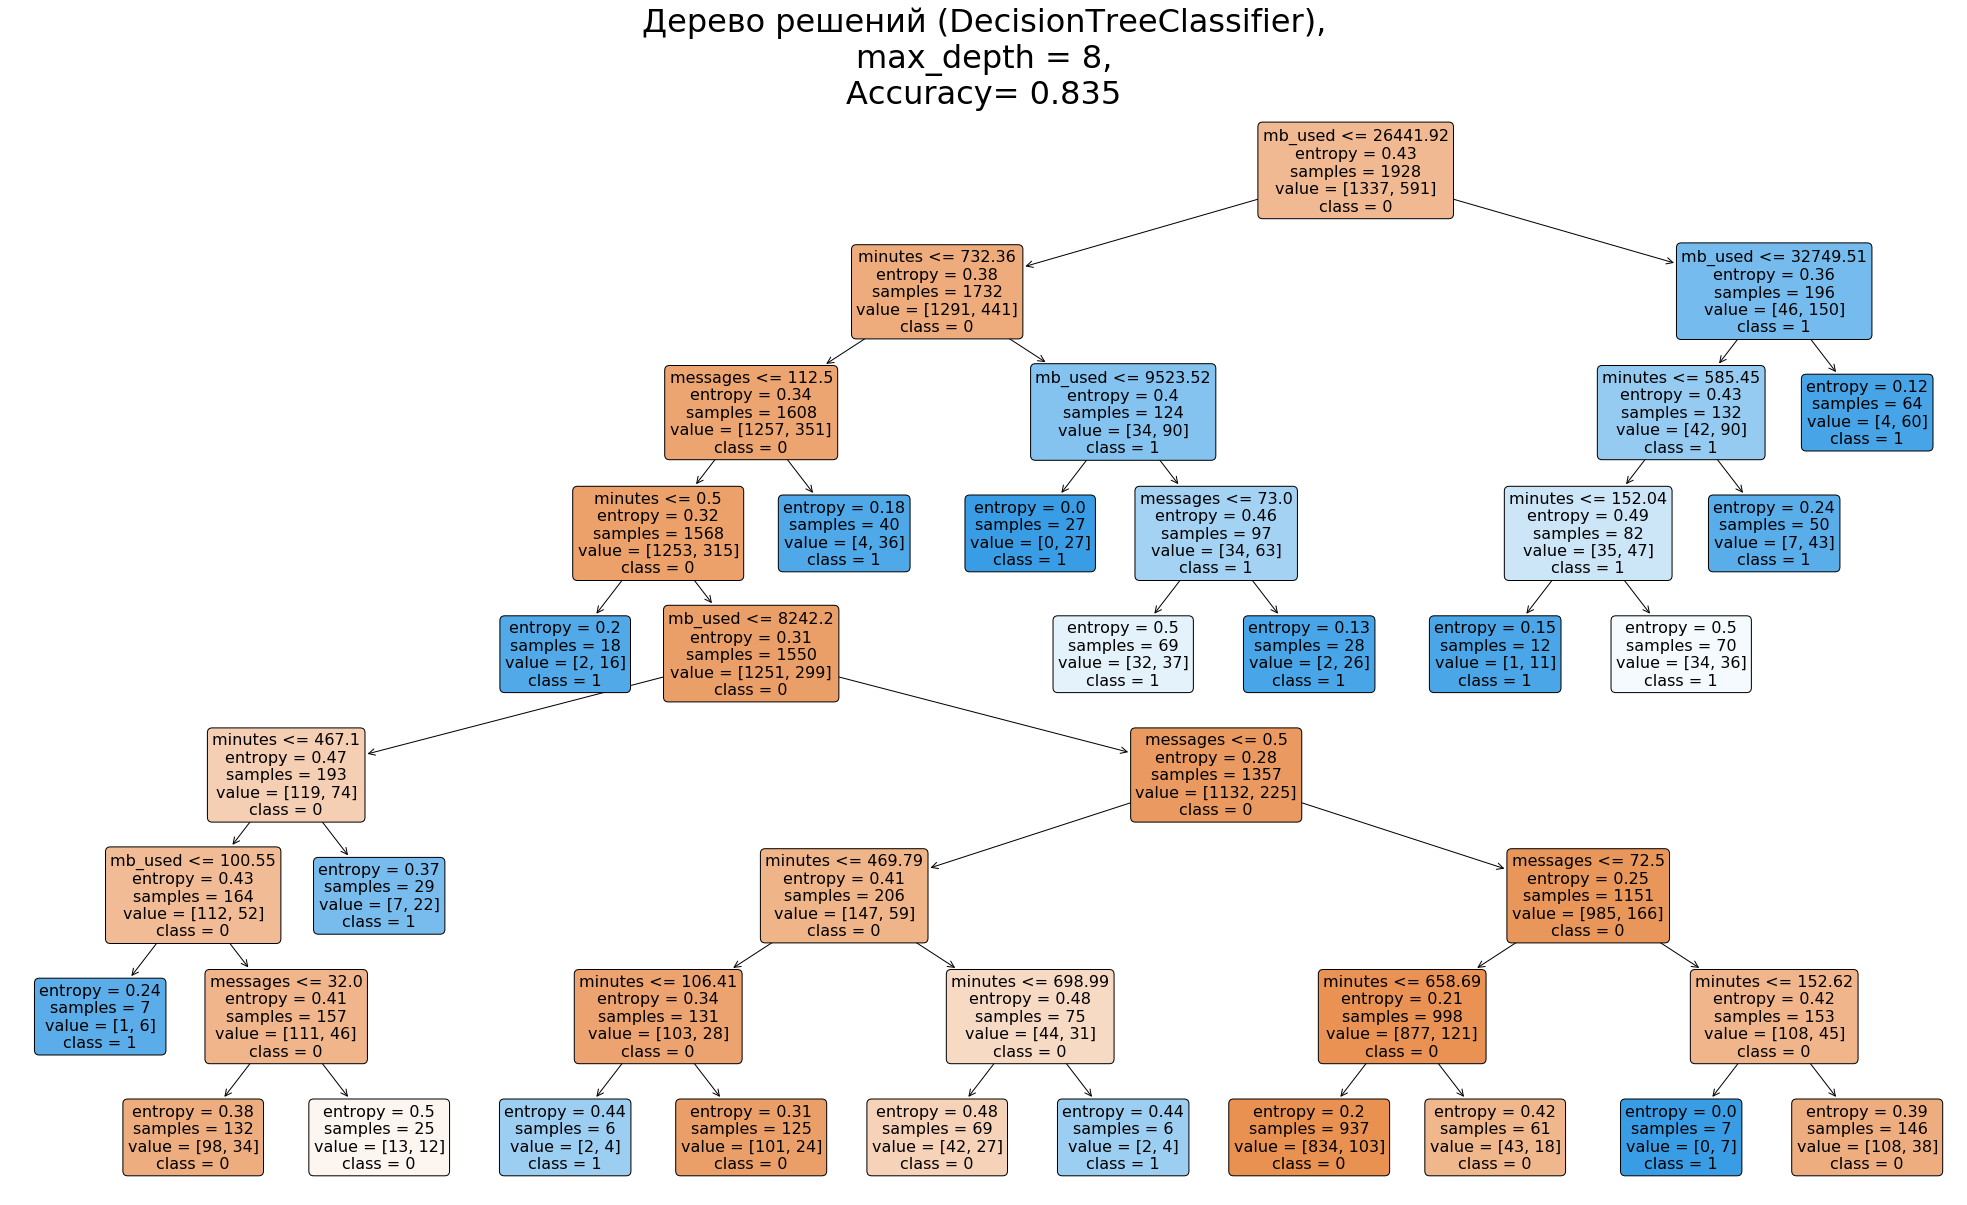

In [94]:
model_dtc = DecisionTreeClassifier(random_state=0, max_depth=best_score_dtc['max_depth'],
                                  min_samples_split=best_score_dtc['min_samples_split'],
                                  min_samples_leaf=best_score_dtc['min_samples_leaf']
                                  )
model_dtc.fit(X_train, y_train)

prediction_dtc = model_dtc.predict(X_valid)
accuracy_dtc = accuracy_score(y_valid, prediction_dtc)

fig, ax = plt.subplots()
fig.set_size_inches(35, 20)
tree.plot_tree(model_dtc, ax=ax, feature_names=list(X.columns), class_names='01',
              fontsize=16, filled=True, rounded=True, precision=2, label ='all')

plt.title('Дерево решений (DecisionTreeClassifier),\nmax_depth = {:.0f},\nAccuracy= {:.3f}'\
          .format(best_score_dtc['max_depth'], accuracy_dtc), fontsize=32)
plt.show()

---

## Случайный лес решений (RandomForestClassifier)

In [95]:
model_rfc = RandomForestClassifier(random_state=0, n_estimators=3)

model_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=3,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [96]:
prediction_rfc = model_rfc.predict(X_valid)
accuracy_rfc = accuracy_score(y_valid, prediction_rfc)
print('Доля правильных ответов модели на основе Леса решений', accuracy_rfc)

Доля правильных ответов модели на основе Леса решений 0.7838258164852255


#### Улучшим модель RandomForestClassifier

<p>Из <a href="https://scikit-learn.org/stable/modules/ensemble.html#random-forest-parameters" title="https://scikit-learn.org/ 1.11.2.3. Parameters¶">
parameter tuning guidelines</a> лучшие результаты обычно подбирабтся при изменении параметров `n_estimators` и `max_features` </p> 

Также на сложность модели влияют параметры `min_samples_split`, `max_leaf_nodes`, `max_depth` и `min_samples_leaf`
При этом хорошее сочетание дают `max_depth=None` и `min_samples_split=2` (проверили - Accuracy меньше, будем менять)

Предлагается проверить наилучшую модель в диапазонах(первоначальный подбор параметров):
 + `n_estimators`: 3, 15;
 + `max_depth` : 4, 16;
 + `max_features`: {“auto”, “sqrt”, “log2”};
 + `min_samples_split`: 2, 16;
 + `min_samples_leaf`: 1, 12;
 + `bootstrap` : {True, False}
 + `criterion` : {'gini', 'entropy'}

Выполнили подбор по первоначальным диапазонам, для примера в коде остановился на диапазонах, которые указаны ниже в коде (для сокращениея времени ожидания)
Выполняли при помощи GridSearchCV - качество модели достигается хуже


код для GridSearchCV:
```python
%%time
randomforest_param = {
    'n_estimators'      : np.arange(8, 15, 2),
    'max_features'      : ['auto', 'sqrt', 'log2'],
    'max_depth'         : np.arange(5, 16, 3),
    'min_samples_split' : np.arange(2, 13, 5),
    'min_samples_leaf'  : np.arange(14, 24, 3),
    'bootstrap'         : [True, False]
}

model = GridSearchCV(RandomForestClassifier(random_state=0),
                     randomforest_param,
                     cv=5
                    )
model.fit(X_train, y_train)
**Out:**
    CPU times: user 3min 31s, sys: 1.06 s, total: 3min 32s
    Wall time: 3min 33s

        
model.best_score_ 
**Out:**
    0.8018672199170125

    
model.best_params_ 
**Out:**
    {'bootstrap': False,
     'max_depth': 11,
     'max_features': 'auto',
     'min_samples_leaf': 14,
     'min_samples_split': 2,
     'n_estimators': 10}
```

In [97]:
%%time
best_score_rfc = {
    'accuracy'          : 0,
    'random_state'      : 0,
    'n_estimators'      : 0,
    'max_features'      : 0,
    'max_depth'         : 0,
    'min_samples_split' : 0,
    'min_samples_leaf'  : 0,
    'bootstrap'         : 0,
    
}

for n_estim in range(4, 12, 2):
    for features in {'auto', 'sqrt', 'log2'}:
        for depth in range(3, 13, 3):
            for min_split in range(2, 50, 10):
                for min_leaf in range(14, 21, 3):                
                    for boot_strap in (True, False):
                                           
                        _model_rfc = RandomForestClassifier(random_state=0,
                                                            n_estimators=n_estim,
                                                            max_features=features,
                                                            max_depth=depth,
                                                            min_samples_split=min_split,
                                                            min_samples_leaf=min_leaf,
                                                            bootstrap=boot_strap,
                                                            criterion='gini'
                                                           )
                        _model_rfc.fit(X_train, y_train)

                        _prediction_rfc = _model_rfc.predict(X_valid)
                        _accuracy_rfc = accuracy_score(y_valid, _prediction_rfc)

                        if _accuracy_rfc > best_score_rfc['accuracy']:
                            best_score_rfc['accuracy']  = _accuracy_rfc
                            best_score_rfc['max_features']  = features
                            best_score_rfc['n_estimators'] = n_estim
                            best_score_rfc['max_depth'] = depth
                            best_score_rfc['min_samples_split'] = min_split
                            best_score_rfc['min_samples_leaf'] = min_leaf
                            best_score_rfc['bootstrap'] = boot_strap

            
print('\nЛучший результат Accuracy = {:.5f} при:'.format(best_score_rfc['accuracy']))
print('\tn_estimators = {:.0f}'.format(best_score_rfc['n_estimators']))
print('\tmax_features = {}'.format(best_score_rfc['max_features']))
print('\tmax_depth = {:.0f}'.format(best_score_rfc['max_depth']))
print('\tmin_samples_split = {:.0f}'.format(best_score_rfc['min_samples_split']))
print('\tmin_samples_leaf = {:.0f}'.format(best_score_rfc['min_samples_leaf']))
print('\tbootstrap = {}'.format(best_score_rfc['bootstrap']))



Лучший результат Accuracy = 0.84759 при:
	n_estimators = 10
	max_features = sqrt
	max_depth = 12
	min_samples_split = 42
	min_samples_leaf = 20
	bootstrap = False
CPU times: user 36.8 s, sys: 143 ms, total: 36.9 s
Wall time: 37.1 s


In [98]:
best_score_rfc

{'accuracy': 0.8475894245723172,
 'random_state': 0,
 'n_estimators': 10,
 'max_features': 'sqrt',
 'max_depth': 12,
 'min_samples_split': 42,
 'min_samples_leaf': 20,
 'bootstrap': False}

Обучим модель на наилучших полученых параметрах

In [99]:
model_rfc = RandomForestClassifier(random_state=0,
                                    n_estimators=best_score_rfc['n_estimators'],
                                    max_features=best_score_rfc['max_features'],
                                    max_depth=best_score_rfc['max_depth'],
                                    min_samples_split=best_score_rfc['min_samples_split'],
                                    min_samples_leaf=best_score_rfc['min_samples_leaf'],
                                    bootstrap=best_score_rfc['bootstrap']
                                   )
model_rfc.fit(X_train, y_train)

prediction_rfc = model_rfc.predict(X_valid)
accuracy_rfc = accuracy_score(y_valid, prediction_rfc)
print('Accuracy: ',accuracy_rfc)

Accuracy:  0.8475894245723172


### Проверим модели на тренировочной и валидационной выборке

In [100]:
models = {
    'Логистическая регрессия' : model_lr,
    'Дерево решений' : model_dtc,
    'Лес решений' : model_rfc
}

dfsets = {'Тренировочная' : (X_train, y_train), 'Валидационная' : (X_valid, y_valid)}

In [101]:
for dfset in dfsets:
    print(f'\n{dfset} выборка')
    
    for model in models:
        _predict = models[model].predict(dfsets[dfset][0])
        _accur   = accuracy_score(dfsets[dfset][1], _predict)
        print(f'Accuracy модели {model} составляет: {_accur:.4f}')   


Тренировочная выборка
Accuracy модели Логистическая регрессия составляет: 0.7386
Accuracy модели Дерево решений составляет: 0.8164
Accuracy модели Лес решений составляет: 0.8247

Валидационная выборка
Accuracy модели Логистическая регрессия составляет: 0.7496
Accuracy модели Дерево решений составляет: 0.8351
Accuracy модели Лес решений составляет: 0.8476


## Вывод

### 1. Построено 3 модели:
 + Логистической регрессии;
 + Дерево решений;
 + Случайный лес решений
2. Модели обучались на тренировочной выборке X_tarin
3. Проверка точности предсказаний моделей производилась на валидационной выборке y_valid
4. Лучшие достигнутые показатели точности моделей составили:
 + Логистической регрессии: 0.7496;
 + Дерева решений: 0.8320;
 + Лес решений: 0.8476.
 

# 4. Проверка модели

### Проверим полученные модели на тестовой выборке

In [102]:
best_model = {'model_name': 0, 'accuracy' : 0}
for model in models:
    _predict = models[model].predict(X_test)
    _accur   = accuracy_score(y_test, _predict)
    print(f'Accuracy модели {model} составляет: {_accur:.4f}')
    
    if _accur > best_model['accuracy']:
        best_model['model_name'] = model
        best_model['accuracy']   = _accur
print('\nВывод:')        
print(f'Лучший результат показала модель {best_model["model_name"]}, равный {best_model["accuracy"]}')

Accuracy модели Логистическая регрессия составляет: 0.7543
Accuracy модели Дерево решений составляет: 0.7963
Accuracy модели Лес решений составляет: 0.7932

Вывод:
Лучший результат показала модель Дерево решений, равный 0.7962674961119751


### Проведем экспиремент (_exp)

Обучим имеющиеся модели на совмещенной выборке тренировочного сета и валидоционного, для увеличения количества входных данных и проверим на тестовой выборке
Для этого воспользуемся еще раз `train_test_split` c `random_state=0` для сохранения тестовой выборки

Обучим модели Дерева решений с параметрами `best_score_dtc`, Лес решений `best_score_rfc`

In [103]:
 X_train_exp, X_test, y_train_exp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [104]:
model_lr_exp = LogisticRegression(C=1.0, penalty='l1', solver='liblinear', random_state=0)
model_lr_exp.fit(X_train_exp, y_train_exp)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [105]:
model_dtc_exp = DecisionTreeClassifier(random_state=0, max_depth=best_score_dtc['max_depth'],
                                  min_samples_split=best_score_dtc['min_samples_split'],
                                  min_samples_leaf=best_score_dtc['min_samples_leaf'])
model_dtc_exp.fit(X_train_exp, y_train_exp)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=75,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

In [106]:
model_rfc_exp = RandomForestClassifier(random_state=0,
                                    n_estimators=best_score_rfc['n_estimators'],
                                    max_features=best_score_rfc['max_features'],
                                    max_depth=best_score_rfc['max_depth'],
                                    min_samples_split=best_score_rfc['min_samples_split'],
                                    min_samples_leaf=best_score_rfc['min_samples_leaf'],
                                    bootstrap=best_score_rfc['bootstrap'],
                                    criterion='gini'
                                   )
model_rfc_exp.fit(X_train_exp, y_train_exp)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=12, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=42,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### Проверим результат

In [107]:
models_exp = {
    'Логистическая регрессия' : model_lr_exp,
    'Дерево решений' : model_dtc_exp,
    'Лес решений' : model_rfc_exp
}

In [108]:
dfsets_exp = {'Тренировочная' : (X_train_exp, y_train_exp), 'Тестовая' : (X_test, y_test)}

for dfset in dfsets_exp:
    print(f'\n{dfset} выборка')
    
    for model in models_exp:
        _predict = models_exp[model].predict(dfsets_exp[dfset][0])
        _accur   = accuracy_score(dfsets_exp[dfset][1], _predict)
        print(f'Accuracy модели {model} составляет: {_accur:.4f}') 
    
        if (_accur > best_model['accuracy']) and (dfset == 'Тестовая'):
            best_model['model_name'] = model
            best_model['accuracy']   = _accur
print('\nВывод:')        
print(f'Лучший результат показала модель {best_model["model_name"]}, равный {best_model["accuracy"]}')


Тренировочная выборка
Accuracy модели Логистическая регрессия составляет: 0.7452
Accuracy модели Дерево решений составляет: 0.8246
Accuracy модели Лес решений составляет: 0.8363

Тестовая выборка
Accuracy модели Логистическая регрессия составляет: 0.7636
Accuracy модели Дерево решений составляет: 0.8056
Accuracy модели Лес решений составляет: 0.7885

Вывод:
Лучший результат показала модель Дерево решений, равный 0.8055987558320373


In [109]:
print(classification_report(y_test, model_dtc_exp.predict(X_test), target_names=['not_ultra', 'is_ulta']))

              precision    recall  f1-score   support

   not_ultra       0.83      0.91      0.87       446
     is_ulta       0.74      0.56      0.64       197

    accuracy                           0.81       643
   macro avg       0.78      0.74      0.75       643
weighted avg       0.80      0.81      0.80       643



1. Модель более качественно предсказывает признак 0 (precision =83%), чем 1 (precision =74%)
2. Модель выделила 91% соответствующий 0 и 56% соотвествующиех 1

In [110]:
joblib.dump(model_dtc_exp, 'DecisTree_project_sprint_6.joblib')

['DecisTree_project_sprint_6.joblib']

## Вывод

1. Лучший средний результат на валидационной и на тестовой выборке показала модель Дерева решений
2. Максимальная доля правильных решений составила 0.8056

## 5. Проверка модели на адекватность

В качестве проверки на вменяемость используем метку наибольшего класса (`is_ultra == 0`) <br/>
Для этого создадим переменную в виде Серии значений равных нулю и длиной соответствующую длине тестовой выборки

In [111]:
sanity_check = pd.Series([0 for i in range(len(y_test))]).values

In [112]:
accuracy_score(y_test, sanity_check)

0.6936236391912908

Доля правильных ответов модели выше почти на 11%, следовательно можно принять, что модель вменяема